In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import TensorBoard
from IPython.display import display, Image, SVG

graph.style.use('fivethirtyeight')

def plot_number(xi, yi=''):
    graph.figure(figsize=(1, 1))
    graph.title('{}'.format(yi))
    graph.imshow(xi.reshape(28, 28), cmap='Greys')
    graph.grid(False)
    graph.show()

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/kaggle_mnist/train.csv')
print(data.info())

y = data.pop('label').values
x = data.values

print(y.shape, x.shape)
print(y[:5])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
(42000,) (42000, 784)
[1 0 1 4 0]


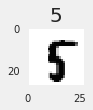

In [3]:
pos = np.random.randint(0, len(y))
plot_number(x[pos, :], y[pos])

# Train Model

(29400, 784) (12600, 784) (29400, 10) (12600, 10)


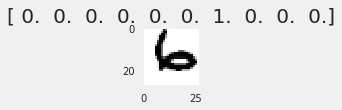

(29400, 28, 28, 1) (12600, 28, 28, 1) (29400, 10) (12600, 10)


In [4]:
# Encode
y_onehot = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1, 1))
x_minmax = x / 255

# Train Test Split
x_train, x_val, y_train, y_val = train_test_split(x_minmax, y_onehot, test_size=0.3)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

plot_number(x_train[0, :], y_train[0, :])

x_train, x_val = x_train.reshape(len(x_train), 28, 28, 1), x_val.reshape(len(x_val), 28, 28, 1)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

In [5]:
# Initialise Type
input_layer = Input(shape=(28, 28, 1))

# Convolutional Layers
cnn = Conv2D(filters=32, kernel_size=(1, 1), activation='relu')(input_layer)
cnn = Conv2D(filters=32, kernel_size=(4, 4), padding='same', activation='relu')(cnn)
cnn = MaxPool2D(pool_size=(2, 2))(cnn)

cnn = Conv2D(filters=64, kernel_size=(1, 1), activation='relu')(cnn)
cnn = Conv2D(filters=64, kernel_size=(4, 4), activation='relu')(cnn)
cnn = MaxPool2D(pool_size=(2, 2))(cnn)

cnn = Conv2D(filters=128, kernel_size=(1, 1), activation='relu')(cnn)
cnn = Conv2D(filters=128, kernel_size=(4, 4), activation='relu')(cnn)
cnn = MaxPool2D(pool_size=(2, 2))(cnn)

cnn = Flatten()(cnn)

# Deep Fully Connected Layers
dnn = Dense(128, activation='relu')(cnn)
dnn = Dropout(0.15)(dnn)
dnn = Dense(128, activation='relu')(dnn)
dnn = Dropout(0.15)(dnn)

dnn = Dense(y_onehot.shape[1], activation='softmax')(dnn)

# Create Models
cnn_model = Model(input_layer, cnn)
dcnn_model = Model(input_layer, dnn)

# Summaries
print('Convo Model')
cnn_model.summary()

print('-'*30)
print('DNN Model')
dcnn_model.summary()

# Compile
dcnn_model.compile(
    loss=categorical_crossentropy,
    optimizer=Adam(lr=5e-4),
    metrics=['accuracy']
)

Convo Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        2112      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0        

In [6]:
# Train Model
history = dcnn_model.fit(
    x_train, y_train,
    epochs=13, validation_split=0.25, batch_size=256,
    verbose=1
)

Train on 22050 samples, validate on 7350 samples
Epoch 1/13
22050/22050 [==============================] - 29s - loss: 0.9736 - acc: 0.6787 - val_loss: 0.1897 - val_acc: 0.9412
Epoch 2/13
22050/22050 [==============================] - 29s - loss: 0.1939 - acc: 0.9399 - val_loss: 0.1188 - val_acc: 0.9638
Epoch 3/13
22050/22050 [==============================] - 28s - loss: 0.1225 - acc: 0.9633 - val_loss: 0.0858 - val_acc: 0.9736
Epoch 4/13
22050/22050 [==============================] - 27s - loss: 0.0937 - acc: 0.9715 - val_loss: 0.0654 - val_acc: 0.9816
Epoch 5/13
22050/22050 [==============================] - 28s - loss: 0.0677 - acc: 0.9793 - val_loss: 0.0967 - val_acc: 0.9733
Epoch 6/13
22050/22050 [==============================] - 29s - loss: 0.0663 - acc: 0.9797 - val_loss: 0.0465 - val_acc: 0.9865
Epoch 7/13
22050/22050 [==============================] - 28s - loss: 0.0518 - acc: 0.9839 - val_loss: 0.0507 - val_acc: 0.9857
Epoch 8/13
22050/22050 [==============================]

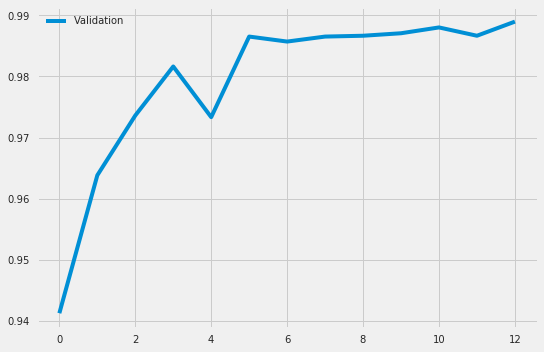

In [7]:
graph.plot(history.history['val_acc'], label='Validation')
graph.legend(loc=0)
graph.show()

In [8]:
test_score = dcnn_model.evaluate(x_val, y_val, verbose=1)

print()
for metric, number in zip(dcnn_model.metrics_names, test_score):
    print('{}: {}'.format(metric, number))

12480/12600 [============================>.] - ETA: 0s
loss: 0.05735875407299895
acc: 0.9842857142857143


# Add Decision Trees to the Ensemble 

Running on features created from the convolution layers of the DCNN.

# Test Set

Let's hope...

In [9]:
test_set = pd.read_csv('data/kaggle_mnist/test.csv')
print(test_set.info())
print(test_set.columns)
print(test_set.index)
print(test_set.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
None
Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
RangeIndex(start=0, stop=28000, step=1)
(28000, 784)


(28000,)


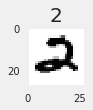

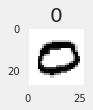

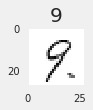

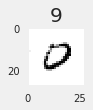

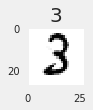

In [11]:
# answers
x_test = test_set.values.reshape(len(test_set), 28, 28, 1)
x_test = x_test / 255
y_answer = dcnn_model.predict(x_test)
y_answer = np.argmax(y_answer, axis=1)
print(y_answer.shape)

for x_eg, y_eg in zip(test_set.values[:5, :], y_answer[:5]):
    plot_number(x_eg, y_eg)

In [ ]:
answer_df = pd.DataFrame(
    y_answer,
    index=list(range(1, len(y_answer)+1)),
    columns=['Label']
)
answer_df.index.name = 'ImageId'

print(answer_df.info())
display(answer_df.head())

answer_df.to_csv('data/kaggle_mnist/submission.csv', index=True, header=True)